In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from ct_img.lib import Roi, create_3d_image, cor_view, sag_view
import numpy as np
from numpy import typing as npt
from matplotlib import pyplot as plt
from skimage import (
    filters,
    measure,
    morphology,
    segmentation,
    transform,
    feature,
    draw,
    color,
)
from scipy import ndimage as ndi
import copy

Load a 3d image of a patient and get a slice from axial, coronal and saggital view.

In [8]:
patient = "normal_hip/JOR01"
# x, y, z
roi = Roi(610, 1350, 920, 1380, 0, 650)
img_3d = create_3d_image(roi, patient)

axial_view = img_3d[:, :, 355]
coronal_view = cor_view(img_3d, 120)
saggital_view = sag_view(img_3d, 200)

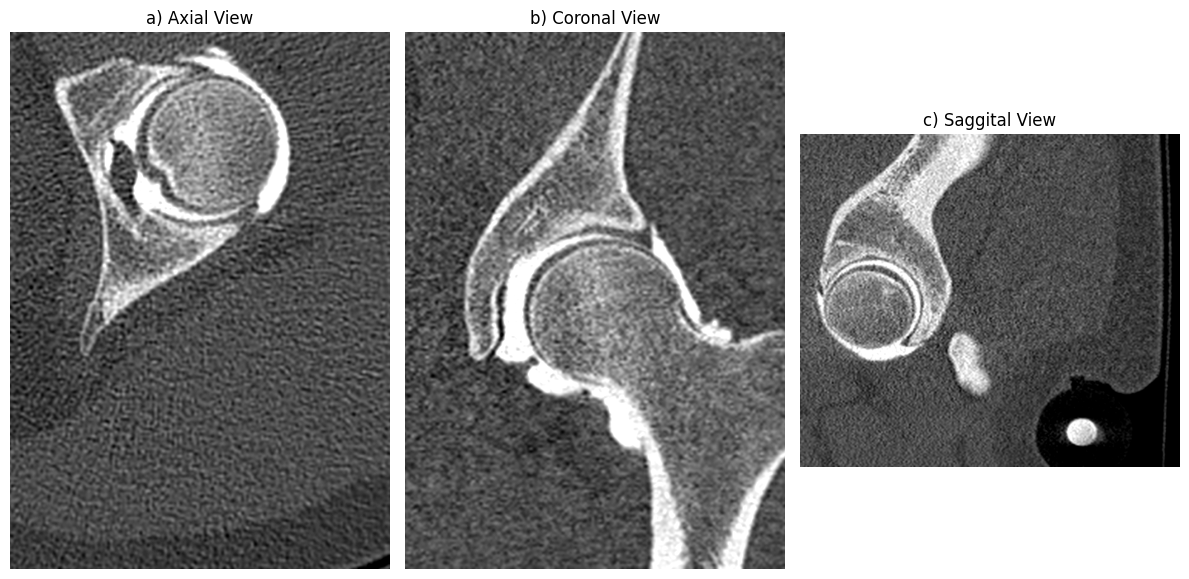

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6), sharey=True)

ax[0].imshow(axial_view, cmap=plt.cm.gray)
ax[0].set_title("a) Axial View")

ax[1].imshow(coronal_view, cmap=plt.cm.gray)
ax[1].set_title("b) Coronal View")

ax[2].imshow(saggital_view, cmap=plt.cm.gray)
ax[2].set_title("c) Saggital View")

for a in ax.ravel():
    a.set_axis_off()
fig.tight_layout()

- Edge detection:
    - Raw -> Sobel -> Canny
- Selection area bones:
    - Raw -> Blurred -> Thres -> Filled -> Keep Largest -> Selection mask of Area.
- Selection area around femoral head:
    - Canny edge masked with selection area bones -> Hough Circle -> Mask with circle radius + epsilon
- Segmentation of cartilidge:
    - Sobel -> Watershed with bins found in selection area around femoral head -> Keep large areas

In [41]:
def segment_image(img: npt.NDArray):
    smooth = filters.gaussian(img, sigma=3)

    thresh_value = filters.threshold_otsu(smooth)
    thresh = smooth > thresh_value

    fill = ndi.binary_fill_holes(thresh)

    # Remove small objects
    labelled = measure.label(fill)
    rp = measure.regionprops(labelled)
    size = max([i.area for i in rp])
    clear = morphology.remove_small_objects(fill, min_size=size - 100)

    selection = np.where(clear, img, 0)

    # Use hough circle to find the femoral head in the selected area
    sobel = filters.sobel(img)
    canny = feature.canny(sobel, sigma=1.5)

    selected_canny = np.where(clear, canny, 0)
    hough_radii = np.arange(100, 200, 2)
    hough_res = transform.hough_circle(selected_canny, hough_radii)

    (
        accum,
        cx,
        cy,
        radii,
    ) = transform.hough_circle_peaks(
        hough_res,
        hough_radii,
        total_num_peaks=1,
    )
    circled = np.zeros_like(selection)
    center_y, center_x, radius = 0, 0, 0
    if len(cx) > 0:
        center_y, center_x, radius = cy[0], cx[0], radii[0]
        circ_y, circ_x = draw.circle_perimeter(
            center_y,
            center_x,
            radius,
            shape=selection.shape,
        )

        circled[circ_y, circ_x] = 1
        circled = morphology.dilation(circled, morphology.disk(radius=20))
    circled = np.where(circled, 255, img)

    # To find our desired place to look for contrast dye we go a little beyond the circle.
    mask = np.zeros_like(img)
    circ_y, circ_x = draw.circle_perimeter(
        center_y,
        center_x,
        radius + 35,
        shape=selection.shape,
    )
    mask[circ_y, circ_x] = 1

    mask = morphology.flood(
        mask,
        (center_y, center_x),
        connectivity=1,
    )
    selected_circle = np.where(mask, img, 0)

    # segment the cartilage: find markers inside the circled area and perform watershed
    fg, bg = 1, 2
    markers = np.zeros_like(img)
    markers[selected_circle < 200] = bg
    markers[selected_circle > 230] = fg

    ws = segmentation.watershed(sobel, markers)
    seg = measure.label(ws == fg)

    unique, nunique = np.unique(seg, return_counts=True)

    indices = []
    min_pixels_seg = 500
    for i, v in enumerate(nunique):
        if v > min_pixels_seg:
            indices.append(i)

    wanted_seg = np.where(np.isin(seg, unique[indices]), seg, 0)
    colored_img = color.label2rgb(wanted_seg, image=img, bg_label=0)

    fig, ax = plt.subplots(3, 4, figsize=(12, 12), sharey=True)

    ax = ax.ravel()

    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].set_title("Raw")

    ax[1].imshow(sobel, cmap=plt.cm.gray)
    ax[1].set_title("Sobel")

    ax[2].imshow(canny, cmap=plt.cm.gray)
    ax[2].set_title("Canny edge detection")

    ax[3].imshow(smooth, cmap=plt.cm.gray)
    ax[3].set_title("Blurred")

    ax[4].imshow(thresh, cmap=plt.cm.gray)
    ax[4].set_title("Threshold")

    ax[5].imshow(clear, cmap=plt.cm.gray)
    ax[5].set_title("Fill and keep largest")

    ax[6].imshow(selection, cmap=plt.cm.gray)
    ax[6].set_title("Selection")

    ax[7].imshow(circled, cmap=plt.cm.gray)
    ax[7].plot(center_x, center_y, "wx")
    ax[7].set_title("Circle the femoral head")

    ax[8].imshow(selected_circle, cmap=plt.cm.gray)
    ax[8].set_title("Selection Circle")

    ax[9].imshow(np.where(markers == 2, 0, 1), cmap=plt.cm.gray)
    ax[9].set_title("Watershed Markers")

    cmap_ws = copy.copy(plt.get_cmap("tab20"))
    cmap_ws.set_under("black")
    ax[10].imshow(seg, cmap=cmap_ws, vmin=1)
    ax[10].set_title("Watershed")

    ax[11].imshow(colored_img)
    ax[11].set_title("Segmented image")

    for a in ax:
        a.set_axis_off()
    fig.tight_layout()
    plt.show()

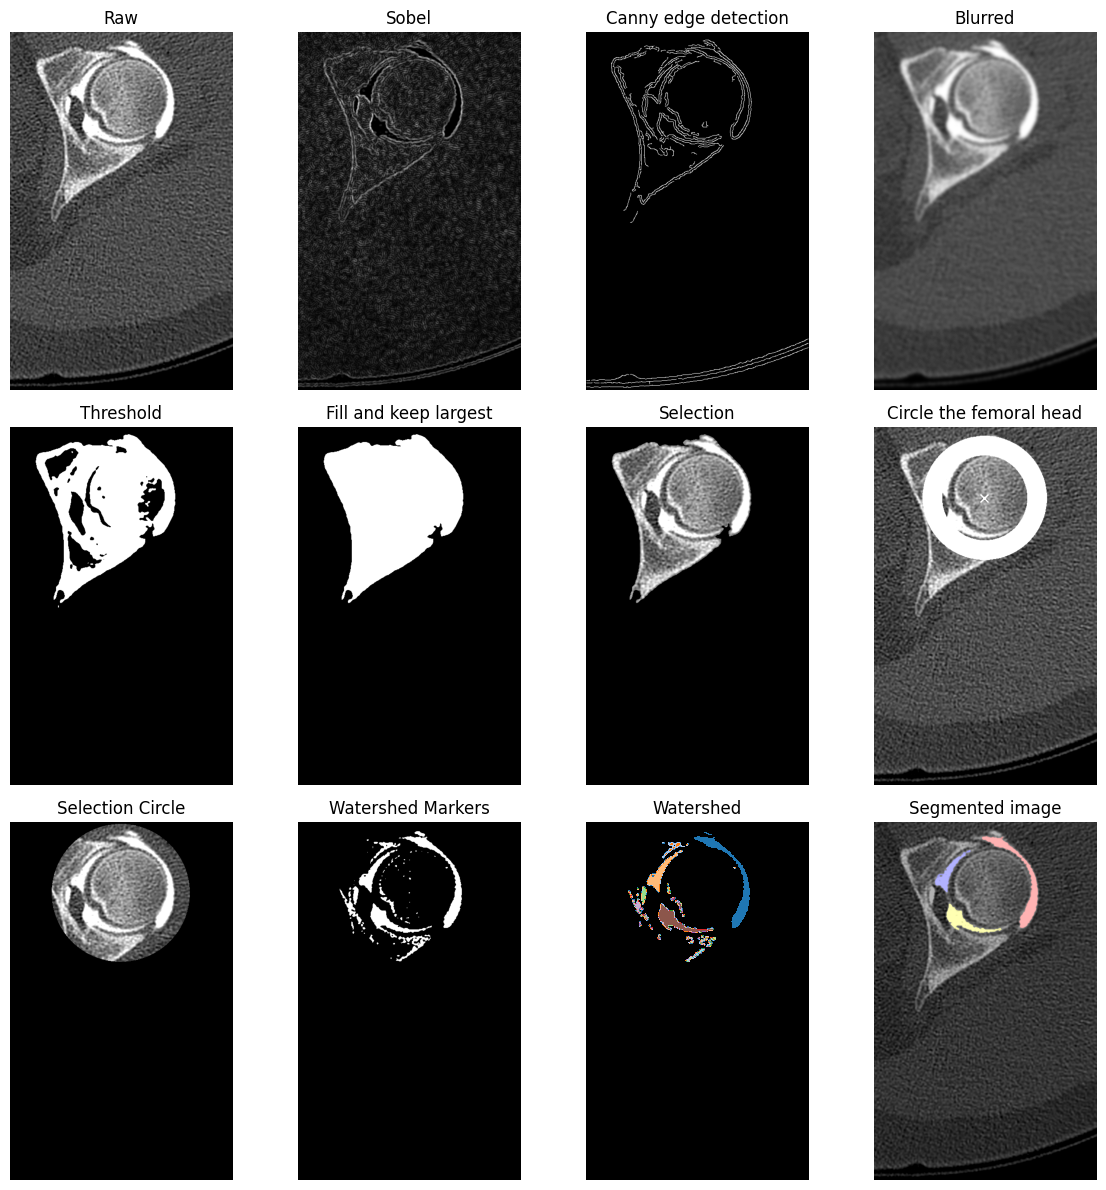

In [42]:
segment_image(axial_view)

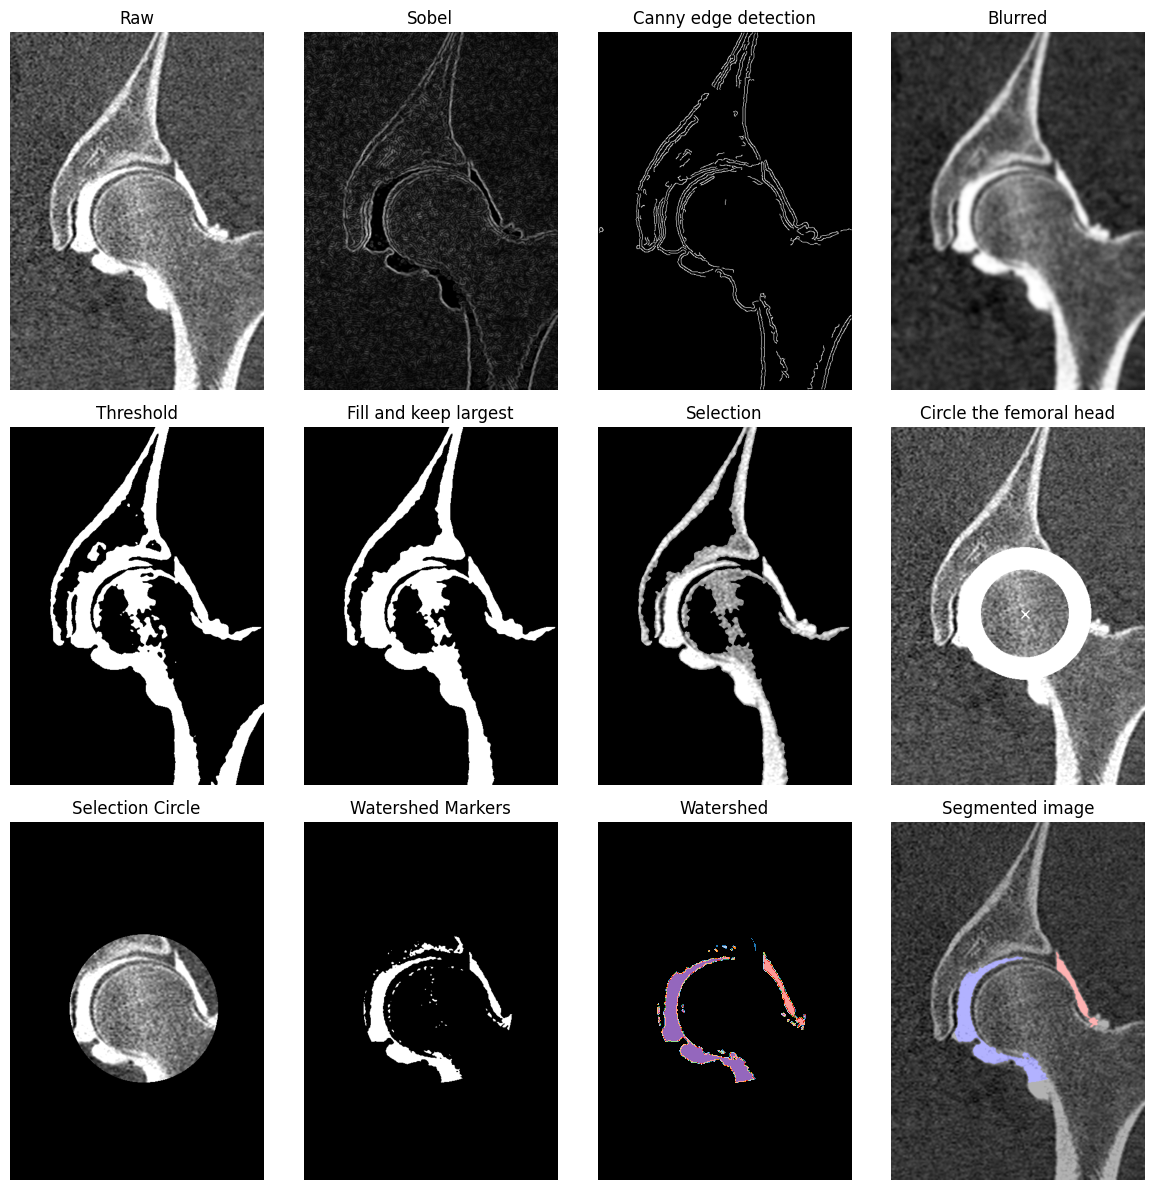

In [37]:
segment_image(coronal_view)

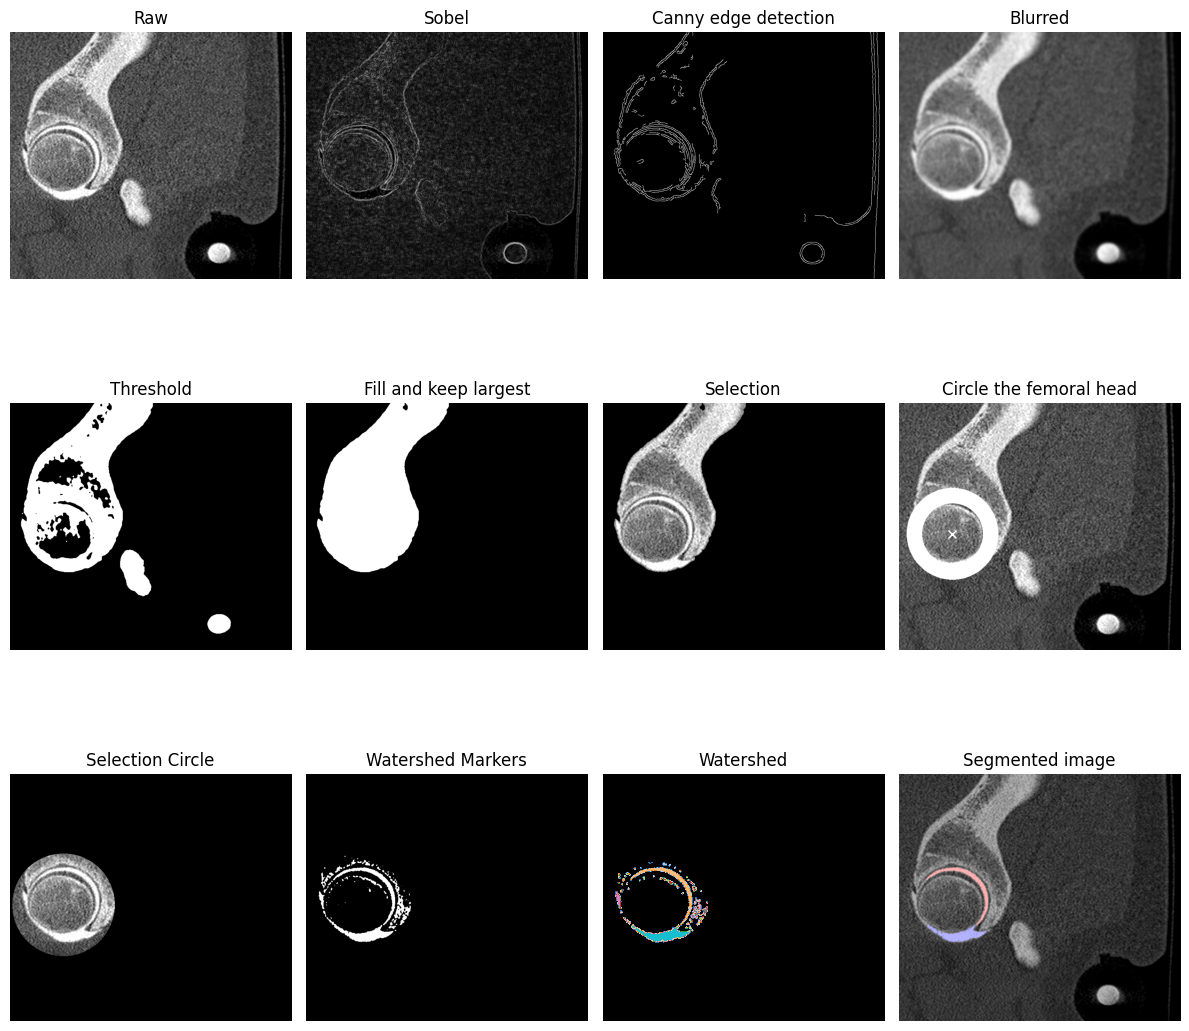

In [43]:
segment_image(saggital_view)